In this tutorial, I will explain how to build a simple deep learning model in theano in few lines of code. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.externals import joblib
import pandas as pd
import redis
import numpy as np 
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from operator import itemgetter
import itertools
import redis
from collections import Counter
from ast import literal_eval as ast_literal_eval
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
pd.options.display.max_colwidth = 250

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
from IPython.display import Image
from IPython.display import SVG
import timeit

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

#### Mnist Dataset

In [5]:
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

In [6]:
train_X, train_y = digits.images, digits.target

In [7]:
train_X = train_X.reshape((train_X.shape[0], -1))

In [8]:
train_X.shape, train_y.shape

((1797, 64), (1797,))

In [9]:
num_examples = 1797 

nn_input_dim = 64
nn_hdim = 100
nn_output_dim = 10

epsilon = 0.01
reg_lambda = 0.01

In [10]:
# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

In [11]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

In [12]:
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2)

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 

# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

In [13]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

In [14]:
# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

In [15]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [1]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=10000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

In [2]:
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

# Plot the decision boundary
#plot_decision_boundary(lambda x: predict(x))
#plt.title("Decision Boundary for hidden layer size 3")

NameError: global name 'np' is not defined

In [18]:
predicted = predict(train_X)

In [19]:
print("Classification report for classifier %s\n"% metrics.classification_report(train_y, predicted))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(train_y, predicted))

Classification report for classifier              precision    recall  f1-score   support

          0       0.99      0.99      0.99       178
          1       0.95      0.99      0.97       182
          2       1.00      0.99      1.00       177
          3       0.99      0.98      0.99       183
          4       0.99      0.98      0.99       181
          5       0.95      0.98      0.96       182
          6       0.99      0.99      0.99       181
          7       0.99      0.99      0.99       179
          8       0.95      0.94      0.94       174
          9       0.97      0.96      0.97       180

avg / total       0.98      0.98      0.98      1797


Confusion matrix:
[[176   0   0   0   1   1   0   0   0   0]
 [  0 180   0   0   0   1   0   0   1   0]
 [  0   1 176   0   0   0   0   0   0   0]
 [  0   0   0 180   0   2   0   0   1   0]
 [  0   0   0   0 177   0   0   1   3   0]
 [  0   1   0   0   0 178   1   0   0   2]
 [  1   0   0   0   0   0 179   0   1   0]
 [  

#### Playing with circles

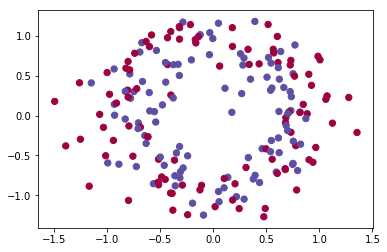

In [20]:
# Generate a dataset and plot it
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_circles(200, noise=0.20)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral)

In [21]:
train_X.shape

(200, 2)

In [22]:
num_examples = train_X.shape[0]

nn_input_dim = train_X.shape[1]
nn_hdim = 3
nn_output_dim = 2

epsilon = 0.01
reg_lambda = 0.01

In [23]:
# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

In [24]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

In [25]:
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2)

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 

# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

In [26]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

In [27]:
# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

In [28]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [29]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=20000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

Loss after iteration 0: 0.719836
Loss after iteration 1000: 0.690394
Loss after iteration 2000: 0.687079
Loss after iteration 3000: 0.683641
Loss after iteration 4000: 0.680088
Loss after iteration 5000: 0.676599
Loss after iteration 6000: 0.673198
Loss after iteration 7000: 0.669727
Loss after iteration 8000: 0.665972
Loss after iteration 9000: 0.661784
Loss after iteration 10000: 0.657145
Loss after iteration 11000: 0.652146
Loss after iteration 12000: 0.646953
Loss after iteration 13000: 0.641769
Loss after iteration 14000: 0.636811
Loss after iteration 15000: 0.632267
Loss after iteration 16000: 0.628255
Loss after iteration 17000: 0.624804
Loss after iteration 18000: 0.621879
Loss after iteration 19000: 0.619408


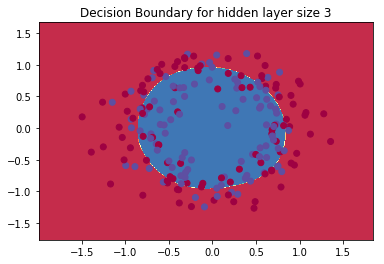

In [30]:
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Decision Boundary for hidden layer size 3")

#### Arbitrary shapes

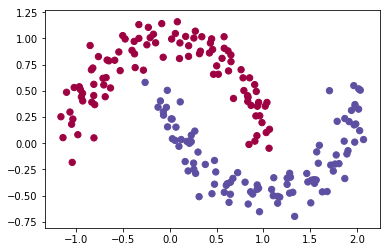

In [35]:
# Generate a dataset and plot it
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_moons(n_samples=200, noise=0.1)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral)

In [36]:
train_X.shape

(200, 2)

In [37]:
num_examples = train_X.shape[0]

nn_input_dim = train_X.shape[1]
nn_hdim = 10
nn_output_dim = 2

epsilon = 0.01
reg_lambda = 0.01

In [38]:
# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

In [39]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

In [40]:
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2)

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 

# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

In [41]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

In [42]:
# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

In [43]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [44]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=20000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

Loss after iteration 0: 0.606703
Loss after iteration 1000: 0.294009
Loss after iteration 2000: 0.267106
Loss after iteration 3000: 0.253663
Loss after iteration 4000: 0.240027
Loss after iteration 5000: 0.221973
Loss after iteration 6000: 0.199240
Loss after iteration 7000: 0.174627
Loss after iteration 8000: 0.151283
Loss after iteration 9000: 0.130867
Loss after iteration 10000: 0.113743
Loss after iteration 11000: 0.099631
Loss after iteration 12000: 0.088042
Loss after iteration 13000: 0.078491
Loss after iteration 14000: 0.070565
Loss after iteration 15000: 0.063934
Loss after iteration 16000: 0.058339
Loss after iteration 17000: 0.053576
Loss after iteration 18000: 0.049489
Loss after iteration 19000: 0.045954


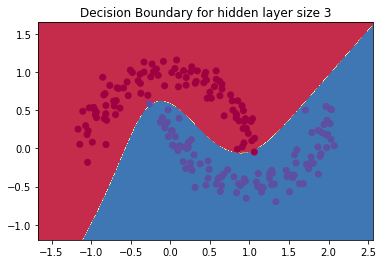

In [45]:
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Decision Boundary for hidden layer size 3")

#### New classification dataset

In [46]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_classification(n_samples=20000, n_features=300)
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_X = train_X.astype(np.float32)
test_X = test_X.astype(np.float32)
train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

In [47]:
train_X.shape, test_X.shape

((16000, 300), (4000, 300))

In [48]:
num_examples = train_X.shape[0]

nn_input_dim = train_X.shape[1]
nn_hdim = 100
nn_output_dim = 2

epsilon = 0.01
reg_lambda = 0.01

In [49]:
# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

In [50]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

In [51]:
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2)

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 

# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

In [52]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

In [53]:
# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

In [54]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [55]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=3000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

In [56]:
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

Loss after iteration 0: 0.769223
Loss after iteration 1000: 0.355149
Loss after iteration 2000: 0.344097


In [57]:
train_prediction = predict(train_X)
test_prediction = predict(test_X)

In [58]:
print("Classification report for classifier \n%s\n"% metrics.classification_report(train_y, train_prediction))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(train_y, train_prediction))

Classification report for classifier 
             precision    recall  f1-score   support

          0       0.85      0.86      0.85      7978
          1       0.86      0.85      0.85      8022

avg / total       0.85      0.85      0.85     16000


Confusion matrix:
[[6833 1145]
 [1181 6841]]


In [59]:
print("Classification report for classifier \n%s\n"% metrics.classification_report(test_y, test_prediction))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_y, test_prediction))

Classification report for classifier 
             precision    recall  f1-score   support

          0       0.83      0.82      0.83      1995
          1       0.83      0.83      0.83      2005

avg / total       0.83      0.83      0.83      4000


Confusion matrix:
[[1643  352]
 [ 342 1663]]
